# Neural Network Model

In [1]:
#prerequisites
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Defining some basic functions to be used in NN

In [2]:
def oneVSall(y_t):
    y_unique = np.unique(y_t)
    y_final = np.zeros((y_t.shape[0],len(y_unique)))
    for i in range(y_t.shape[0]):
        for j in range(len(y_unique)):
            if y_t[i]==y_unique[j]:
                y_final[i][j]=1
    return y_final

def Prediction(y):
    row_wise_max_value_arr = np.amax(y,axis=1)
    m,n = y.shape
    y_prediction = []
    for i in range(m):
        for j in range(n):
            if row_wise_max_value_arr[i]==y[i][j]:
                y_prediction.append(j)
    return y_prediction

def calculate_accuracy(predictions, true_labels):
    m = predictions.shape[0]
    c=0
    for i in range(m):
        if predictions[i] == true_labels[i] :
            c+=1
    return c/m*100

def softmax(z):
    ans = np.exp(z)/(np.sum(np.exp(z),axis =0,keepdims=True))
    return ans

In [3]:
np.random.seed(7)               #fixing the random vlaues to get same random nos. everytime anyone runs 

## Steps in Neural Network

#### 1 - > Initialize parameters
#### 2 - > Forward propogation
#### 3 - > Cost function 
#### 4 - > Backward propogation
#### 5 - > updating parameters
#### 6 - > Graph
#### 7 - > Accuracy 

### Importing data and visualising it

In [4]:
data_pd = pd.read_csv('train_data/Classification_train.csv')
data_pd

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data = data_pd.to_numpy()
x = data[:,1:]
x_t = x/255 #applying basic normalisation 
y = data[:,0]

### Data visualisation

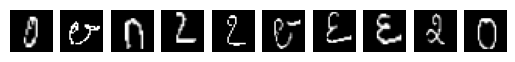

In [6]:
fig ,axs = plt.subplots(1,10)
for i,ax in enumerate(axs):    
    ax.imshow(x_t[i,:].reshape(28,28),cmap='gray')
    ax.axis('off')

### Dividing the data into training and cross validation set 

In [7]:
x_train = x_t[:25000,:].T
x_cv = x_t[25000:]
y_t = y[:25000]
y_train = oneVSall(y_t).T
y_cv = y[25000:]

## Initialising parameters

In [8]:
neurons = [x_train.shape[0],512,256,10] 
#input layer having 784 inputs and 128 is hidden layer and 10 is the output layer [10 in output layer because 10 unique labels in multi class classification problem]

In [9]:
n = len(neurons)
w=[]
b=[]
for i in range(1,n):
        w.append(np.random.randn(neurons[i], neurons[i-1]) *np.sqrt(2/neurons[i-1])) #He Normal initialization used for ReLu
        b.append(np.random.randn(neurons[i], 1) * np.sqrt(2/neurons[i-1]))

## Forward propogation

In [10]:
def forward_prop(x_train,w,b,n): 
    A = [x_train]   #A = the output of each layer
    z = []          #z = wx+b for each layer
    for i in range(n-2):
        z.append(np.matmul(A[i].T,w[i].T).T+b[i])
        A.append(np.maximum(0,z[i]))   #activation function for relu 
    z.append(np.matmul(A[-1].T,w[-1].T).T+b[-1])
    A.append(softmax(z[-1]))
    return z,A

## Cost Function 

In [11]:
def Cost(y_train, A):
    
    L = -y_train * np.log(A[-1])

    C = np.sum(L)

    m = y_train.shape[1]  # number of observations

    Cost = C / m

    return Cost

## Backward propogation

In [12]:
def Backwar_prop(n,A,y_train,w,z):
    dz=[]
    dw=[]
    db=[]
    for i in range(n-1):
         dz.append(0)
    dz[-1] = A[-1] - y_train
    for i in range(n-3,-1,-1):
        dz[i]=(dz[i+1].T@w[i+1]*((z[i]>0)-1).T).T 
    for i in range(n-1):
        dw.append(dz[i]@A[i].T)
    for i in range(n-1):
        db.append(np.sum(dz[i],axis=1,keepdims=True))
    return dz,dw,db

## Updating Parameters => Applying gradient descent

In [13]:
alpha = 0.00007
iterations = 1000
cost_his= []
m=y_train.shape[0]
print("No of iter         Cost")
for i in range(iterations):
    z,A = forward_prop(x_train,w,b,n)
    dz,dw,db = Backwar_prop(n,A,y_train,w,z)
    cost = Cost(y_train,A)
    cost_his.append(cost)
    for j in range(n-1):
        w[j]=w[j]-alpha*(dw[j]/m)
        b[j]=b[j]-alpha*(db[j]/m)
    if i%(iterations//10)==0:
        print(i,"        ",cost)

No of iter         Cost
0          2.30461983355323
100          1.4626123625550538
200          0.9761876095301921
300          0.6138494105843144
400          0.46061198121516195
500          0.4152537377827896
600          0.38784658389362464
700          0.3665548319834625
800          0.34574687363473494
900          0.34321634583050187


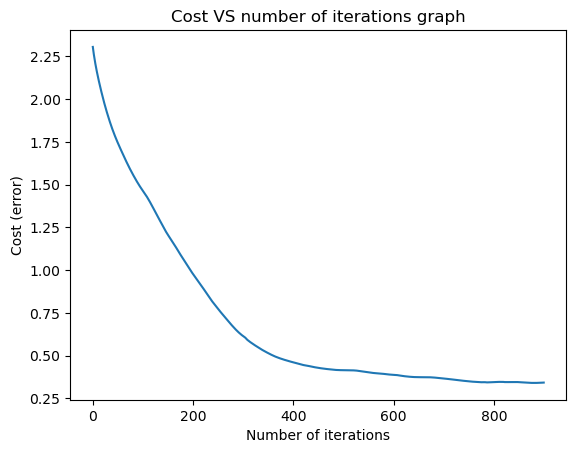

In [28]:
def plotting_costVSnum_iter(cost,num_iter):
    plt.title("Cost VS number of iterations graph")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost (error)")
    plt.plot(np.arange(0,num_iter),cost)
    plt.show()
plotting_costVSnum_iter(cost_his[:900],iterations-100)

In [26]:
calculate_accuracy(np.array(Prediction(A[-1].T)),y_t)

89.18

### Checking Accuracy on cross valdiation set 

In [27]:
z_cv , A_cv = forward_prop(x_cv.T,w,b,n)
calculate_accuracy(np.array(Prediction(A_cv[-1].T)),y_cv)

88.96

## Visualising the output data - predicted vs actual with the image

Left side actual value , Right Side predicted value


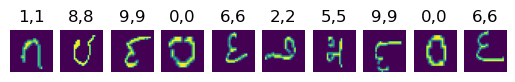

In [17]:
fig,axs = plt.subplots(1,10)
for j,ax in enumerate(axs):
    i = np.random.randint(0,25000)
    a = x_train.T[i,:]
    ax.imshow(a.reshape(28,28))
    ax.set_title(f"{y_t[i]},{np.array(Prediction(A[-1].T))[i]}")
    ax.axis('off')
print("Left side actual value , Right Side predicted value")

## Now making the predicted output file using test data

In [18]:
df2 = pd.read_csv('test_data/Classification_test.csv')
df2

,ID,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,15795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5390,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11964,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11284,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,18563,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,634,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,10057,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_np = df2.to_numpy()
x_tes = df_np[:,1:]
x_test = x_tes/255

In [20]:
z_test , A_test = forward_prop(x_test.T,w,b,n)

In [21]:
final = np.zeros((10000,2))
final[:,0]= df_np[:,0]
final[:,1] = np.array(Prediction(A_test[-1].T))

In [22]:
df= pd.DataFrame(final)
df.columns = ["ID's", 'Predictions']
df

,ID's,Predictions
0,15795.0,0.0
1,860.0,4.0
2,5390.0,5.0
3,11964.0,5.0
4,11284.0,8.0
...,...,...
9995,11260.0,9.0
9996,18563.0,9.0
9997,634.0,0.0
9998,10057.0,8.0


In [23]:
# Saving predictions to CSV
df.to_csv('predicted_data/NeuralNetwork_predicted_final.csv', index=False)